In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
data = pd.read_csv("mushrooms.csv")
data.head(5)

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,p,x,s,n,t,p,f,c,n,k,...,s,w,w,p,w,o,p,k,s,u
1,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
2,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
3,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
4,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g


In [3]:
for i in data.columns:
    data[i]=pd.Categorical(data[i],data[i].unique())
    data[i]=data[i].cat.rename_categories(range(len(data[i].unique())))
data=data.astype(int)
data.head()

,class,cap-shape,cap-surface,cap-color,bruises,odor,gill-attachment,gill-spacing,gill-size,gill-color,...,stalk-surface-below-ring,stalk-color-above-ring,stalk-color-below-ring,veil-type,veil-color,ring-number,ring-type,spore-print-color,population,habitat
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,1,0,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,1,1,1
2,1,1,0,2,0,2,0,0,1,1,...,0,0,0,0,0,0,0,1,1,2
3,0,0,1,2,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,3,1,3,0,1,1,0,...,0,0,0,0,0,0,1,1,2,1


In [4]:
data.shape

(8124, 23)

In [5]:
def split_train_test(data,rate):
    data = np.matrix(data)
    random.shuffle(data)
    s = int(rate*data.shape[0])
    train = data[:s,:]
    test = data[s:]
    train_x = train[:,1:]
    train_y = train[:,0]
    test_x = test[:,1:]
    test_y = test[:,0]
    return train_x,train_y,test_x,test_y

In [6]:
train_x,train_y,test_x,test_y = split_train_test(data,0.85)

In [41]:
class DenseNetwork(object):
    '''
    sigmoid激活函数
    交叉熵损失函数
    '''
    def __init__(self, sizes):
        '''
        层数, 每层神经元数量
        '''
        self.num_layers = len(sizes)
        self.sizes = sizes
        # 初始化参数
        self.weight_initializer()
        self.cost_acc=[]

    def weight_initializer(self):
        '''参数初始化,正态分布'''
        self.biases = [np.random.randn(1, y) for y in self.sizes[1:]]
        self.weights = [np.random.randn(x, y)/np.sqrt(x) for x, y in zip(self.sizes[:-1], self.sizes[1:])]

    def feedforward(self,a,activation_function):
        '''前向传播'''
        for b,w in zip(self.biases,self.weights):
            a = activation_function(np.dot(a,w)+b)
        return a

    def SGD(self, training_data,test_data, epochs, batch_size, eta,lmbda = 0.0):
        '''随机梯度下降'''
        n_data = len(test_data)
        n = len(training_data)
        test_cost, test_accuracy = [], []
        training_cost, training_accuracy = [], []
        for j in range(epochs):
            random.shuffle(training_data)
            batches = [training_data[k:k+batch_size] for k in range(0, n, batch_size)]
            for batch in batches:
                self.update_batch(batch, eta, lmbda, len(training_data))
            print("Epoch %s training complete" % j)
            
            # cost:
            cost1 = self.total_cost(training_data, lmbda)
            training_cost.append(cost1)
            cost2 = self.total_cost(test_data, lmbda)
            test_cost.append(cost2)
            print("训练集损失: {}，测试集损失: {}".format(cost1,cost2))

            # accuracy:
            accuracy1 = self.accuracy(training_data)
            training_accuracy.append(accuracy1)
            accuracy2 = self.accuracy(test_data)
            test_accuracy.append(accuracy2)
            print("训练集准确率: {}，测试集准确率: {} ".format(accuracy1,accuracy2))
        self.cost_acc = [training_cost, training_accuracy,test_cost,test_accuracy]
        return [training_cost, training_accuracy,test_cost,test_accuracy]

    def update_batch(self, batch, eta, lmbda, n):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in batch:
            delta_nabla_b, delta_nabla_w = self.backprop(x, y)
            nabla_b = [nb+dnb for nb, dnb in zip(nabla_b, delta_nabla_b)]
            nabla_w = [nw+dnw for nw, dnw in zip(nabla_w, delta_nabla_w)]
        self.weights = [(1-eta*(lmbda/n))*w-(eta/len(batch))*nw
                        for w, nw in zip(self.weights, nabla_w)]
        self.biases = [b-(eta/len(batch))*nb
                       for b, nb in zip(self.biases, nabla_b)]

    def backprop(self, x, y):
        nabla_b = [np.zeros(b.shape) for b in self.biases]
        nabla_w = [np.zeros(w.shape) for w in self.weights]
        """前向传播"""
        x = np.matrix(x)
        activation = x
        activations = [x]   # 存储sigmoid(z),即每一层的输出
        zs = []             # 存储z (z=wx+b)
        for b, w in zip(self.biases, self.weights):
            z = np.dot(activation, w)+b
            zs.append(z)
            activation = sigmoid(z)
            activations.append(activation)
        '''反向传播
        利用反向传播的四个方程式
        '''
        # 输出层梯度
        delta = f_delta(activations[-1], y)
        nabla_b[-1] = delta.T
        nabla_w[-1] = np.dot(delta, activations[-2]).T
        # 隐层梯度
        for l in range(2, self.num_layers):
            z = zs[-l]
            sp = sigmoid_prime(z)
            delta = np.multiply(np.dot(self.weights[-l+1], delta), sp.T)
            nabla_b[-l] = delta.T
            nabla_w[-l] = np.dot(delta, activations[-l-1]).T
        return (nabla_b, nabla_w)

    def accuracy(self, data):
        n = len(data)
        sum=0
        for x,y in data:
            result = self.feedforward(x,sigmoid)
            if result > 0.5:
                result = 1
            else:
                result = 0
            if result == y:
                sum += 1
        return sum/n

    def total_cost(self, data, lmbda):
        '''计算损失'''
        cost = 0.0
        for x, y in data:
            a = self.feedforward(x,sigmoid)
            cost += fn(a, y)/len(data)
        '''正则化'''
        cost += 0.5*(lmbda/len(data))*sum(np.linalg.norm(w)**2 for w in self.weights)
        return cost
    def visualization(self):
        df = pd.DataFrame(self.cost_acc).T
        df.columns=['training_cost', 'training_accuracy','test_cost','test_accuracy']
        df.plot()
        
def sigmoid(z):
    """sigmoid函数"""
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_prime(z):
    """sigmoid函数的导数"""
    return np.multiply(sigmoid(z),(1-sigmoid(z)))

def fn(a, y):
    """交叉熵损失函数"""
    return np.sum(np.nan_to_num(-y*np.log(a)-(1-y)*np.log(1-a)))

def f_delta(a, y):
    return (a-y)    

In [44]:
sizes = [22,32,16,1]
network = DenseNetwork(sizes)
train_data = list(zip(train_x,train_y))
test_data = list(zip(test_x,test_y))
a = network.SGD(train_data,test_data,30,50,0.1,0.1)

Epoch 0 training complete
训练集损失: 0.5092528823774063，测试集损失: 0.8658738409753571
训练集准确率: 0.789572773352643，测试集准确率: 0.5291222313371616 
Epoch 1 training complete
训练集损失: 0.5120329190630746，测试集损失: 0.7482448436359126
训练集准确率: 0.789572773352643，测试集准确率: 0.5291222313371616 
Epoch 2 training complete
训练集损失: 0.4825829132010661，测试集损失: 0.8141862919709966
训练集准确率: 0.789572773352643，测试集准确率: 0.5291222313371616 
Epoch 3 training complete
训练集损失: 0.4422788624450747，测试集损失: 0.7178226957797829
训练集准确率: 0.789572773352643，测试集准确率: 0.5291222313371616 
Epoch 4 training complete
训练集损失: 0.37438808975528365，测试集损失: 0.6131601116423518
训练集准确率: 0.84605358435916，测试集准确率: 0.6365873666940115 
Epoch 5 training complete
训练集损失: 0.2985720522361625，测试集损失: 0.42183667148079634
训练集准确率: 0.9012309920347574，测试集准确率: 0.8195242001640689 
Epoch 6 training complete
训练集损失: 0.22940726690937097，测试集损失: 0.3993994418747112
训练集准确率: 0.9184648805213613，测试集准确率: 0.8211648892534865 
Epoch 7 training complete
训练集损失: 0.18692122852011314，测试集损失: 0.3363623038

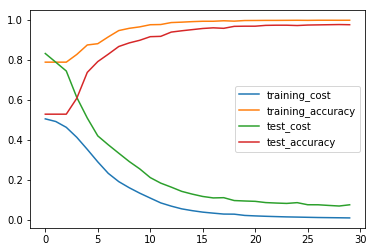

In [43]:
network.visualization()